<a href="https://colab.research.google.com/github/AdamChoong0095/NUS-Stock-Data/blob/Adam/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price CS3244 ARIMA section
The goals of this project are:
* To determine an effective model with justificaiton for predicting stock prices of the S&P500
* To determine if the S&P500 is a good indicator of performance for other companies contained in the top 500 performing companies

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Processing
For every stock or ETF being analysed, we chose to create a continuous data frame by choosing to include the average of the daily high and low as the constant day to day price between opening and closing. We made this decision because of the appropriate statisical representation the mean has of the high and low prices every day.

In [2]:
import pandas as pd
#here is a demonstration of preprocessing done on the S&P500 ETF
sp500=pd.read_csv('/content/drive/MyDrive/cs3244_data/ETFs/spy.us.txt')
sp500.drop(columns={'OpenInt','Volume'}, inplace=True)
def preprocessing_function(data):
  # Create empty lists to store the new data
  dates = []
  prices = []
  price_types = []

  # Iterate through the DataFrame
  for index, row in data.iterrows():
    date = row['Date']
    open_price = row['Open']
    high_price = row['High']
    low_price = row['Low']
    close_price = row['Close']

    # Append the data to the lists
    dates.extend([date] * 4)  # Repeat the date 4 times
    prices.extend([open_price, high_price, low_price, close_price])
    price_types.extend(['open', 'high', 'low', 'close'])

  # Create a new DataFrame
  data = pd.DataFrame({'Date': dates, 'Price': prices, 'Type of Price': price_types})

  grouped = data.groupby(['Date', 'Type of Price'])

  # Calculate the average price for each date and type
  avg_prices = grouped['Price'].mean().reset_index()

  # Create a dictionary to store the average high and low prices for each date
  avg_high_low = {}

  # Iterate through the average prices
  for index, row in avg_prices.iterrows():
    date = row['Date']
    price_type = row['Type of Price']
    price = row['Price']

    if date not in avg_high_low:
      avg_high_low[date] = {}

    if price_type == 'high' or price_type == 'low':
      avg_high_low[date][price_type] = price

  # Iterate through the DataFrame and replace high and low prices with the average
  for index, row in data.iterrows():
    date = row['Date']
    price_type = row['Type of Price']

    if price_type == 'high' or price_type == 'low' and date in avg_high_low:
      data.loc[index, 'Price'] = avg_high_low[date][price_type]

  # Create a new DataFrame to store the modified data
  new_data = pd.DataFrame(columns=['Date', 'Price', 'Type of Price'])

  # Iterate through the DataFrame
  i = 0
  while i < len(data):
    row = data.iloc[i]
    if row['Type of Price'] == 'high':
      # Check if the next row exists and is 'low'
      if i + 1 < len(data) and data.iloc[i + 1]['Type of Price'] == 'low':
        # Calculate the average of the high and low prices
        average_price = (row['Price'] + data.iloc[i + 1]['Price']) / 2
        # Add a new row with the average price and label 'average'
        new_data = pd.concat([new_data, pd.DataFrame({'Date': [row['Date']], 'Price': [average_price], 'Type of Price': ['average']})], ignore_index=True)
        i += 2  # Skip the next row (low)
      else:
        # If the next row is not 'low', keep the current row as it is
        new_data = pd.concat([new_data, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
        i += 1
    else:
      # If the current row is not 'high', keep it as it is
      new_data = pd.concat([new_data, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
      i += 1
  return new_data
sp500=preprocessing_function(sp500)
sp500_pivot = sp500.pivot(index='Date', columns='Type of Price', values='Price')
sp500_pivot.reset_index(inplace=True)
sp500_pivot

Type of Price,Date,average,close,open
0,2005-02-25,105.340,105.79,104.77
1,2005-02-28,105.120,105.08,105.55
2,2005-03-01,105.545,105.62,105.22
3,2005-03-02,105.660,105.57,105.21
4,2005-03-03,105.675,105.61,105.99
...,...,...,...,...
3196,2017-11-06,258.610,258.85,258.30
3197,2017-11-07,258.730,258.67,258.97
3198,2017-11-08,258.685,259.11,258.47
3199,2017-11-09,257.375,258.17,257.73


## Method
To achieve the first goal, we will tune hyperparameters of different models to achieve the best performance possible for each type of model (based on multiple metrics)
* Split data into 80/20 proportion (4 years of training to predict 1 year of prices) to mitigate the effect of overfitting or underfitting. For training/validation, we try cross validation on time series (recommended but more computationally expensive, see code below)
* Select models appropriate for the time series context.
* Compare between model types and ascertain the best model for predicting prices based on a standardised set of metrics.
* Apply the selected model to an assortment of companies contained in the S&P500.
* The purpose of doing this will be to demonstrate whether or not this approach of model selection generalises well on stock price prediction.

The reasoning behind this approach is that the S&P500 is a traditional indicator (by definition) of the performance of the 500 most dominant stocks in Wall Street.

#### Model selection process
The main process applied particularly to the models designated for handling time series data such as ARIMA and ARCH during selection will be as follows:
* Cross validate the model over hyperparameter space
* Fit the model selected from the cross validation process
* Conduct one or multiple hypothesis tests to discover if the model has a good fit to the data or needs improvements.

In [3]:
#perform time series splitting (instead of stochastic selection of subsets, we select ordered subsets to train and validate models)
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
def split_data(data,proportion):
  train_size=int(len(data)*proportion)
  data_train = data[:train_size]
  data_test = data[train_size:]
  return data_train,data_test

Now we will start using time series specific modelling techniques that can capture the sequential nature of our data because of our project's method which is to use historical prices to predict future prices.

### (Seasonal) ARIMA approach

ARIMA models are typically the first type of model we consider when trying to model time series data. ARIMA is modelled after the following equation:

$$
Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

where:

$$
\Delta^d Y_t = (1 - B)^d Y_t
$$

and

$$
\epsilon_t \sim \text{white noise}
$$

Firstly, we apply normal ARIMA methods. ARIMA models only work effectively against stationary data. Our data is not staitonary. The evidence against stationarility on our data set can be shown through a p test. We use an Augmented Dickey Fuller hypothesis test for this. In the ADF test, here are the simplified hypotheses for our context.

Null hypothesis: data is not stationary

Alternative hypothesis: data is stationary

In [4]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity using ADF test
result = adfuller(sp500_pivot['average'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation:
# If p-value < 0.05, the series is stationary.

ADF Statistic: 1.4394553962415115
p-value: 0.9972862135344689


As expected, there is overwhelming evidence based on the p-value, that the data is not stationary. To account for the non-stationary nature of our data, we apply a differencing transformation, that is we predict the differences or volatility in stock prices rather than the actual stock price itself so the data remains stationary.

In [5]:
#Applied differencing transformation to make data stationary
for column in ['open', 'average','close']:
  sp500_pivot[f'{column}_diff'] = sp500_pivot[column].diff().fillna(0)


We now visualise both the differences and the actual price side by side to see the effect of the transformation.

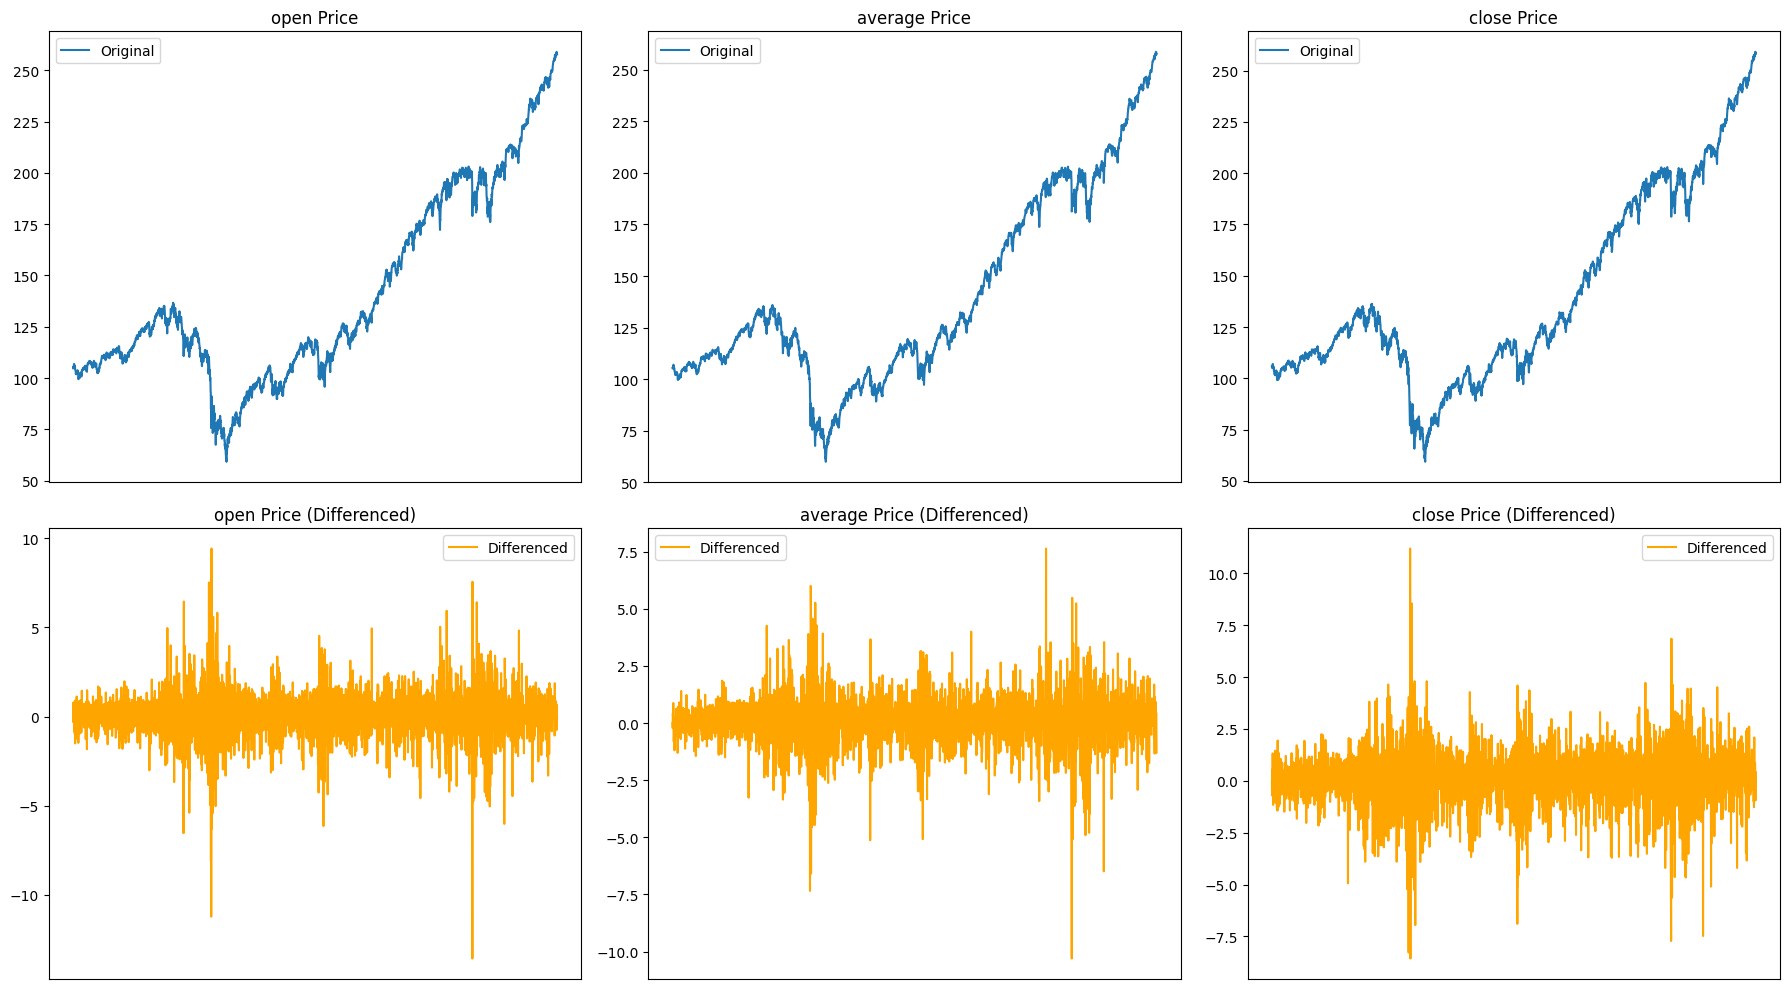

In [6]:
# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

# 1. Extract unique years, handling 'yy-mm-dd' format
years_in_data = pd.to_datetime(sp500_pivot['Date'], format='%Y-%m-%d').dt.year.unique()

# 2. Create custom tick locations using years_in_data
tick_locations = [mdates.date2num(pd.to_datetime(f'{year}-01-01')) for year in years_in_data]
tick_labels = years_in_data.astype(str)

# 3. Iterate through subplots and apply custom ticks and labels
for i in range(3):
    axes[0, i].set_xticks(tick_locations)
    axes[0, i].set_xticklabels(tick_labels, rotation=45, ha='right')
    axes[1, i].set_xticks(tick_locations)
    axes[1, i].set_xticklabels(tick_labels, rotation=45, ha='right')

# Plot the data
price_types = ['open', 'average', 'close']
for i, price_type in enumerate(price_types):
    # Plot original prices
    axes[0, i].plot(sp500_pivot['Date'], sp500_pivot[price_type], label='Original')
    axes[0, i].set_title(f'{price_type} Price')
    axes[0, i].legend()

    # Plot differenced prices
    axes[1, i].plot(sp500_pivot['Date'], sp500_pivot[f'{price_type}_diff'], label='Differenced', color='orange')
    axes[1, i].set_title(f'{price_type} Price (Differenced)')
    axes[1, i].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [7]:
# Redo check for stationarity using ADF test on differenced data
result = adfuller(sp500_pivot['close_diff'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation:
# If p-value < 0.05, the series is stationary.

ADF Statistic: -12.489142144865175
p-value: 2.972267302768441e-23


According to the hypothesis test, there is strong evidence against the null so we reject the hypothesis that the data is not stationary. This is the desired outcome and now we start testing an ARIMA model to compare predicted and true volatility.

In [8]:
#note that we had to split data after the transformation because this is unlike normalisation
#we are now judging volatility which is completely different from the actual stock price
#split only last 5 years of data into training and testing
#use the opening and average differences as feature variables
#and closing differences as the target because we want to predict closing prices
#since they are considered the "latest" most current state of prices we have before
#the new day arrives
sp500_pivot['Date'] = pd.to_datetime(sp500_pivot['Date'])
new_sp500_pivot=sp500_pivot[sp500_pivot['Date'].dt.year >= 2012]
sp500_train,sp500_test=split_data(new_sp500_pivot,0.8)
X_train,X_test=sp500_train[['open_diff','average_diff']],sp500_test[['open_diff','average_diff']]
y_train,y_test=sp500_train['close_diff'],sp500_test['close_diff']

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from joblib import Parallel, delayed
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

In [10]:
def evaluate_arima_model(X_train, y_train, X_test, y_test, order):
  """Fits an ARIMA model and returns predictions."""
  try:
    # Create and fit the ARIMA model on the training data
    model = ARIMA(y_train, exog=X_train, order=order)  # Include exog for features
    model_fit = model.fit()

    # Make predictions on the testing data
    predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions
    mse = mean_squared_error(y_test, predictions, squared=True)  # Calculate RMSE

    return order, mse  # Return order and MSE
  except Exception as e:
    print(f"Error with order {order}: {e}")  # Print error message
    return None  # Return None for failed configurations

def grid_search_arima_parallel(X_train, y_train, p_values, d_values, q_values,n_jobs, n_splits):
    """
    Performs a grid search for ARIMA model hyperparameters using parallel computing.

    Args:
        X_train (pd.DataFrame): Features for training.
        y_train (pd.Series): Target variable for training.
        p_values (list): List of values for the AR order (p).
        d_values (list): List of values for the differencing order (d).
        q_values (list): List of values for the MA order (q).
        n_jobs (int): Number of CPU cores to use for parallel processing (-1 for all cores).
        n_splits (int): Number of splits for time series cross-validation.

    Returns:
        tuple: Best ARIMA order and its corresponding RMSE.
    """

    best_order = None
    best_mse = float('inf')
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Create a list of all hyperparameter combinations
    order_param_combinations = [(p, d, q) for p in p_values for d in d_values for q in q_values]
    # sorder_param_combinations = [(P, D, Q,s) for P in P_values for D in D_values for Q in Q_values]

    # Evaluate all model configurations in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_arima_model)(
            X_train.iloc[train_idx],  # Features for training split
            y_train.iloc[train_idx],  # Target for training split
            X_train.iloc[validate_idx],  # Features for validation split
            y_train.iloc[validate_idx],  # Target for validation split
            order
        )
        for order in order_param_combinations
        # for sorder in sorder_param_combinations
        for train_idx, validate_idx in tscv.split(X_train)  # Split based on X_train index
    )

    # Filter out failed configurations and find the best model
    valid_results = [result for result in results if result is not None]
    if valid_results:
        best_order, best_mse = min(valid_results, key=lambda x: x[1])

    return best_order, best_mse

We use MSE as the quantifier for selecting the best parameter combination because we know that the magnitude of differences is less than 1 most of the time which could potentially lead of numerical instability issues.

In [11]:
#cross validate
best_order,best_mse=grid_search_arima_parallel(
    X_train=X_train,
    y_train=y_train,
    p_values=range(4),
    d_values=range(4),
    q_values=range(4),
    n_jobs=-1,
    n_splits=3,
)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

RMSE: 0.4859688487722884
MAE: 0.37314982945276665
MSE: 0.23616572197706334


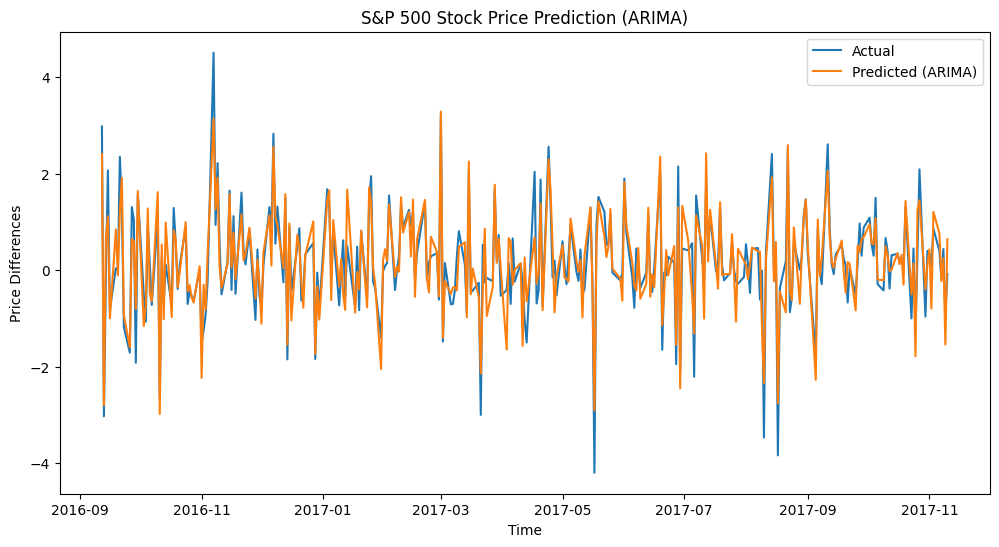

In [12]:
model = ARIMA(y_train, exog=X_train, order=best_order) # Include exog for features
model_fit = model.fit()
# Make predictions on the testing data
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions

rmse = mean_squared_error(sp500_test['close_diff'], predictions, squared=False)
mae = mean_absolute_error(sp500_test['close_diff'], predictions)
mse = mean_squared_error(sp500_test['close_diff'], predictions)
mape = mean_absolute_percentage_error(sp500_test['close_diff'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
plt.figure(figsize=(12, 6))
plt.plot(sp500_test['Date'],sp500_test['close_diff'], label='Actual')
plt.plot(sp500_test['Date'],predictions, label='Predicted (ARIMA)')
plt.title('S&P 500 Stock Price Prediction (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

Let's now reverse the volatility predicitons to the actual predicitons against the actual prices so it's easier to interpret the performance of our model.

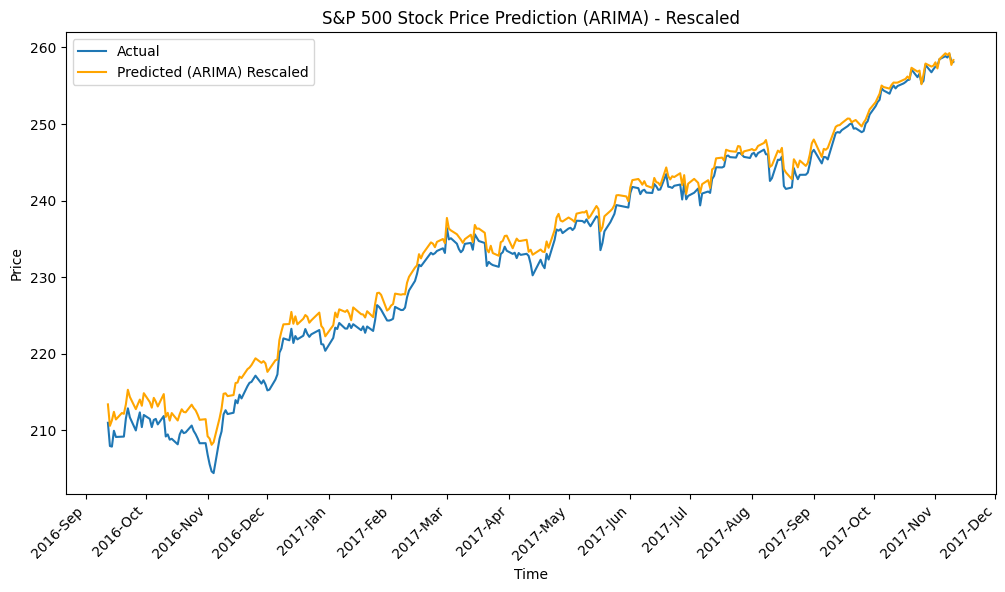

Rescaled RMSE: 1.7337029986793389
Rescaled MAE: 1.5443917092755652
Rescaled MSE: 3.0057260876297316
Rescaled MAPE: 0.006843764900224764


In [13]:
predictions_rescaled = sp500_test['close'].iloc[0] + predictions.cumsum()

# Plot actual vs. rescaled predicted prices
plt.figure(figsize=(12, 6))
plt.plot(sp500_test['Date'], sp500_test['close'], label='Actual')
plt.plot(sp500_test['Date'], predictions_rescaled, label='Predicted (ARIMA) Rescaled', color='orange')
plt.title('S&P 500 Stock Price Prediction (ARIMA) - Rescaled')
# Convert 'Date' column to datetime
sp500_test['Date'] = pd.to_datetime(sp500_test['Date'], format='%Y-%m-%d')

# Extract unique years and create tick locations/labels
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  # Format as 'Year-Month'
plt.xticks(rotation=45, ha='right')  # Rotate for readability

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate evaluation metrics on rescaled prices
rmse_rescaled = mean_squared_error(sp500_test['close'], predictions_rescaled, squared=False)
mae_rescaled = mean_absolute_error(sp500_test['close'], predictions_rescaled)
mse_rescaled = mean_squared_error(sp500_test['close'], predictions_rescaled)
mape_rescaled = mean_absolute_percentage_error(sp500_test['close'], predictions_rescaled)


# Print the evaluation metrics for rescaled predictions
print(f'Rescaled RMSE: {rmse_rescaled}')
print(f'Rescaled MAE: {mae_rescaled}')
print(f'Rescaled MSE: {mse_rescaled}')
print(f'Rescaled MAPE: {mape_rescaled}')

At a glance, the model performs well during most segments. We hypothesise that at sections where poorer performance is evident, this could be attributed to the model's inability to forecast unexpected differences that exceed the magnitude of those found in the training data. Particularly towards the start of the testing period, we see the predictions deviate more from the true price because the volatility pattern may not have been captured during training. Overall, this model performs at an average standard compared to our other models as it actually captures the non-linear patterns of the price quite well but does not excel at accurately doing so.

### (G)ARCH approach
The next model we wanted to explore was ARCH or AutoRegressive Conditional Heteroskedasticity. It is a well-known technique to use when modelling financial returns on an investment. An ARCH model is parameterised as follows:

Let  $y_t$  be a time series that is modeled as:

$$y_t = \mu + \epsilon_t$$

where:

$\mu$  is the mean,
$\epsilon_t$  is the error term, which represents the random changes at time t.

The error term  $\epsilon_t$  is assumed to have the following properties:

* $\epsilon_t$ = $\sigma_t z_t$
* $z_t$  is a white noise process with mean zero and variance 1, i.e.,  $z_t \sim N(0, 1)$ .
$\sigma_t^2$  is the conditional variance at time t.

The conditional variance is calculated as follows:

$\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \cdots + \alpha_q \epsilon_{t-q}^2$

where $\alpha_i$ is a positive weight placed on each term, $\epsilon_{t}$

The heteroskedacity property of the model (the ability to predict changes in error over time) allows for the measurement of volatility. A generalised ARCH adds the element of conditonal variance of the past error term to the model. This is particularly useful in our context because we are under the assumption that historical data (past prices) has a causal effect on predicted prices. It is VERY important to note that GARCH predicts the DIFFERENCE or change in stock prices, not the stock price itself.

However, after debugging failures, we chose not to explore it further. Instead some literature indicates the feasibility of autoregressive regression models on our data. See links below.

Investopedia. (2020). Generalized AutoRegressive Conditional Heteroskedasticity (GARCH) Definition. Investopedia. https://www.investopedia.com/terms/g/garch.asp
‌

Fryzlewicz, P. (2007). Lecture notes: Financial time series, ARCH and GARCH models. http://stats.lse.ac.uk/fryzlewicz/lec_notes/garch.pdf



## Testing on other stocks
Our hypothesis states that our model should be able to perform reasonably well on stocks contained in the S&P500 because the definition of the S&P500 ETF is that it measures the overall performance of the top 500 performing stocks in the market so intuitively, it could be a good measure of performance for a single stock contained in the rankings.

For our first test case, we choose Apple (aapl) which is known to be a dominant stock in the S&P500 and the tech industy. We want to avoid computationally expensive operations whenever possible which is why we avoid cross validation on the data and retain the same hyperparameters as those determined from cross-validating over the S&P500 ETF. The intuition behind this is that the hyperparameters determined from training on the ETF are essentially markers of an optimal model for the stocks within the S&P500.

In [14]:
aapl=pd.read_csv('/content/drive/MyDrive/cs3244_data/Stocks/aapl.us.txt')

In [15]:
aapl=preprocessing_function(aapl)
aapl_pivot = aapl.pivot(index='Date', columns='Type of Price', values='Price')
aapl_pivot.reset_index(inplace=True)

In [16]:
#Applied differencing transformation to make data stationary
for column in ['open', 'average','close']:
  aapl_pivot[f'{column}_diff'] = aapl_pivot[column].diff().fillna(0)

We only consider last 5 years of data to maintain consistency. In addition, it is known that Apple has gone through very unexpected changes before this period of time. Hence, using our model on older data would not provide a fair comparison. (This is evident from the sudden behaviours and extreme price hikes experienced by Apple during the course of its history.)

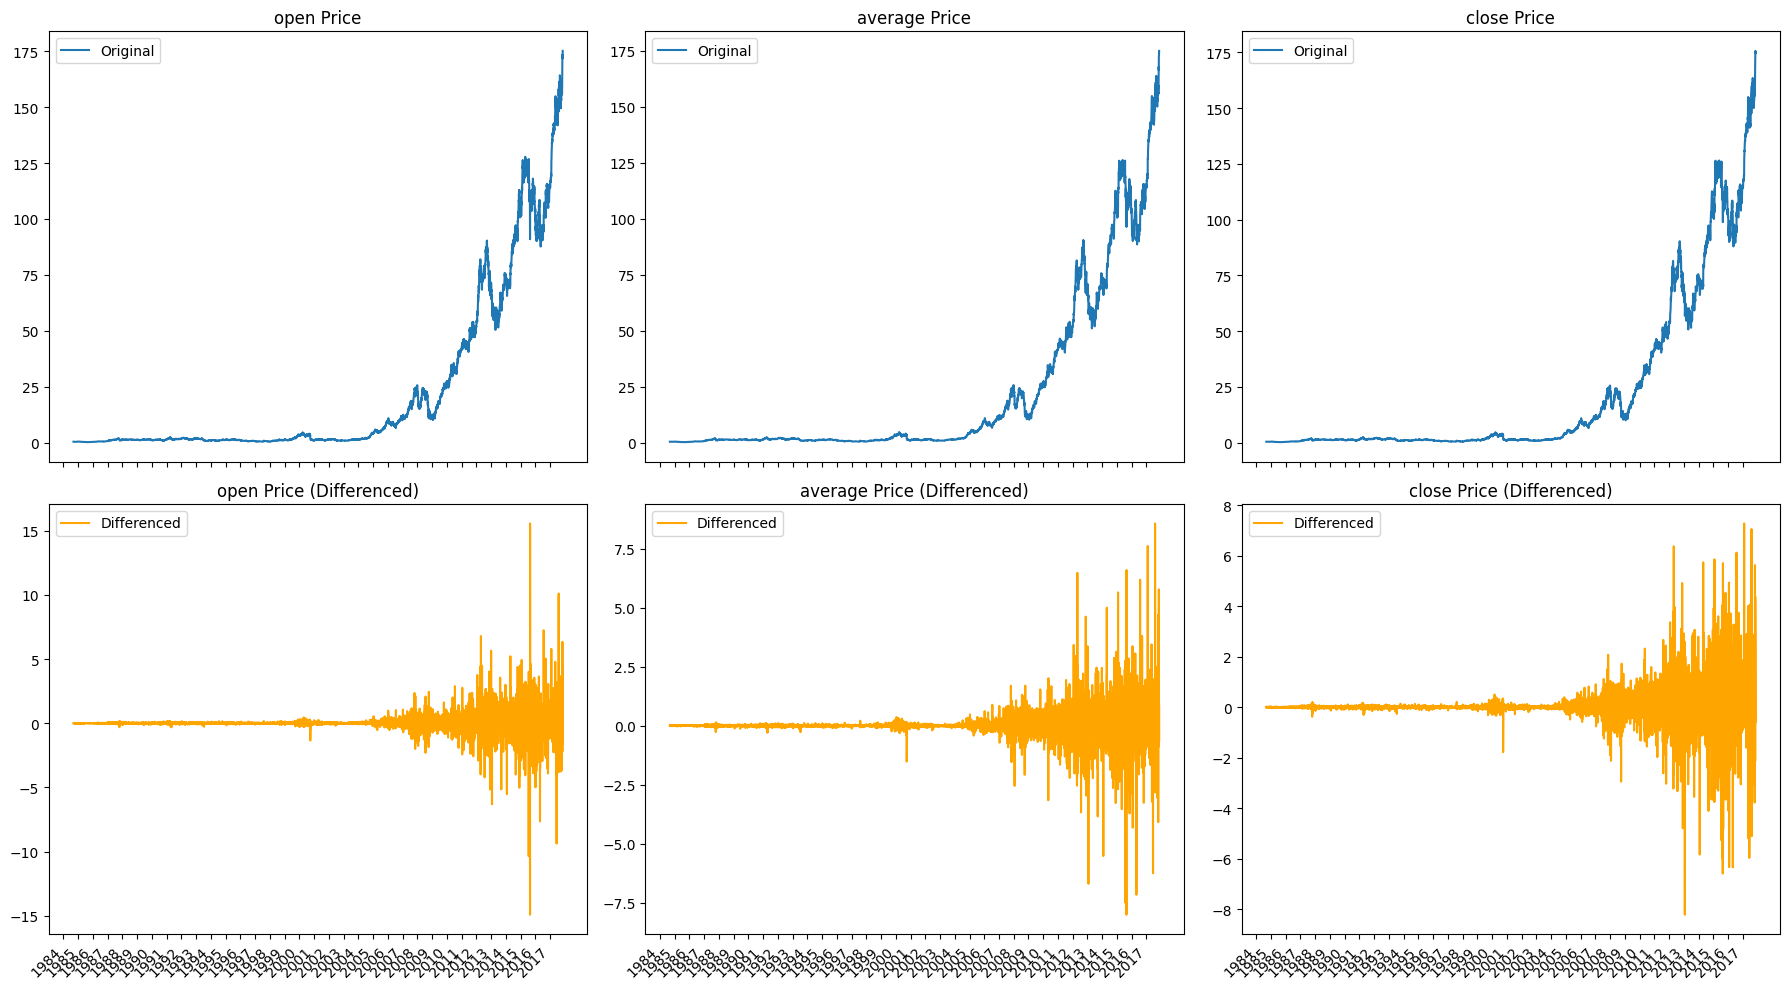

In [17]:
# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
years_in_data = pd.to_datetime(aapl_pivot['Date'], format='%Y-%m-%d').dt.year.unique()
aapl_pivot['Date'] = pd.to_datetime(aapl_pivot['Date'])
tick_locations = [mdates.date2num(pd.to_datetime(f'{year}-01-01')) for year in years_in_data]
tick_labels = years_in_data.astype(str)
# 3. Iterate through subplots and apply custom ticks and labels
for i in range(3):
    axes[0, i].set_xticks(tick_locations)
    axes[0, i].set_xticklabels(tick_labels, rotation=45, ha='right')
    axes[1, i].set_xticks(tick_locations)
    axes[1, i].set_xticklabels(tick_labels, rotation=45, ha='right')

# Plot the data
price_types = ['open', 'average', 'close']
for i, price_type in enumerate(price_types):
    # Plot original prices
    axes[0, i].plot(aapl_pivot['Date'], aapl_pivot[price_type], label='Original')
    axes[0, i].set_title(f'{price_type} Price')
    axes[0, i].legend()

    # Plot differenced prices
    axes[1, i].plot(aapl_pivot['Date'], aapl_pivot[f'{price_type}_diff'], label='Differenced', color='orange')
    axes[1, i].set_title(f'{price_type} Price (Differenced)')
    axes[1, i].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [18]:
new_aapl_pivot=aapl_pivot[aapl_pivot['Date'].dt.year >= 2012]
aapl_train,aapl_test=split_data(new_aapl_pivot,0.8)
X_train,X_test=aapl_train[['open_diff','average_diff']],aapl_test[['open_diff','average_diff']]
y_train,y_test=aapl_train['close_diff'],aapl_test['close_diff']

We want to avoid computationally expensive operations and we have reiterated that the purpose of this project is to test models with the same hyperparameters on different sets of data. Hence, no cross validation will be performed.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

RMSE: 0.6769499568689911
MAE: 0.5271635207110932
MSE: 0.4582612441049288


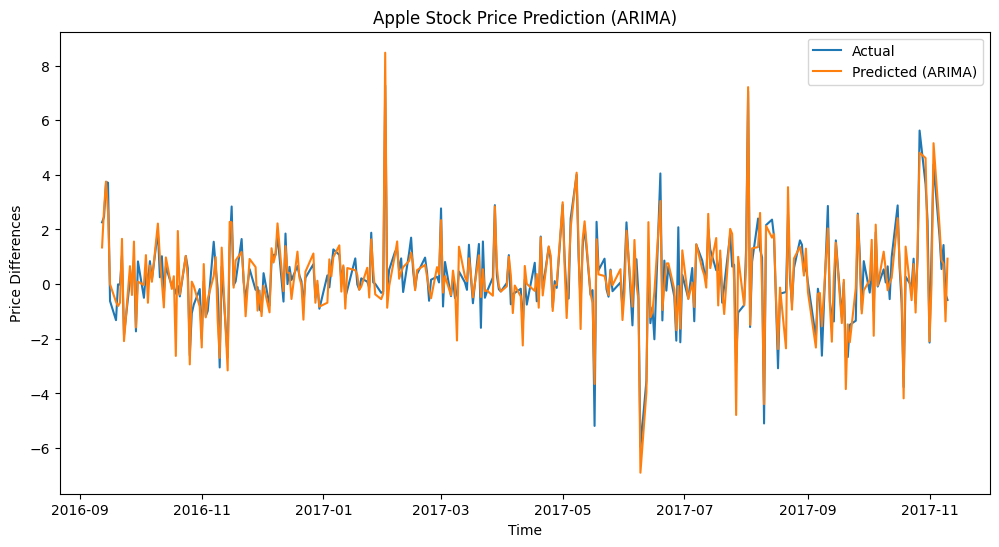

In [19]:
model = ARIMA(y_train, exog=X_train, order=best_order) # Include exog for features
model_fit = model.fit()
# Make predictions on the testing data
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions

rmse = mean_squared_error(aapl_test['close_diff'], predictions, squared=False)
mae = mean_absolute_error(aapl_test['close_diff'], predictions)
mse = mean_squared_error(aapl_test['close_diff'], predictions)
mape = mean_absolute_percentage_error(aapl_test['close_diff'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
plt.figure(figsize=(12, 6))
plt.plot(aapl_test['Date'],aapl_test['close_diff'], label='Actual')
plt.plot(aapl_test['Date'],predictions, label='Predicted (ARIMA)')
plt.title('Apple Stock Price Prediction (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

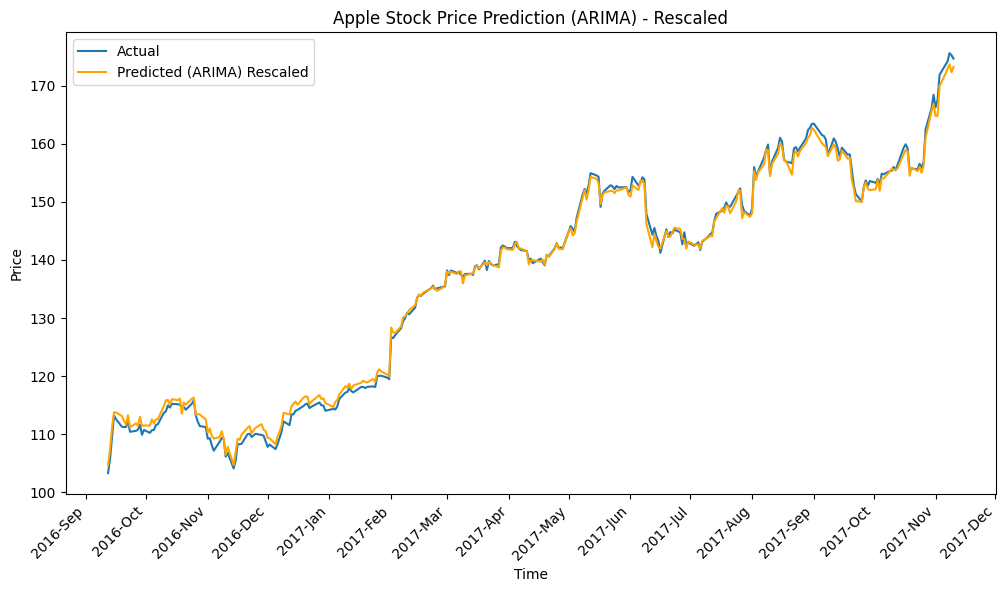

Rescaled RMSE: 0.9565308143871724
Rescaled MAE: 0.7853907822277554
Rescaled MSE: 0.9149511988721872
Rescaled MAPE: 0.4148672850919247


In [20]:
predictions_rescaled = aapl_test['close'].iloc[0] + predictions.cumsum()

# Plot actual vs. rescaled predicted prices
plt.figure(figsize=(12, 6))
plt.plot(aapl_test['Date'], aapl_test['close'], label='Actual')
plt.plot(aapl_test['Date'], predictions_rescaled, label='Predicted (ARIMA) Rescaled', color='orange')
plt.title('Apple Stock Price Prediction (ARIMA) - Rescaled')
# Convert 'Date' column to datetime
aapl_test['Date'] = pd.to_datetime(aapl_test['Date'], format='%Y-%m-%d')

# Extract unique years and create tick locations/labels
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  # Format as 'Year-Month'
plt.xticks(rotation=45, ha='right')  # Rotate for readability

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate evaluation metrics on rescaled prices
rmse_rescaled = mean_squared_error(aapl_test['close'], predictions_rescaled, squared=False)
mae_rescaled = mean_absolute_error(aapl_test['close'], predictions_rescaled)
mse_rescaled = mean_squared_error(aapl_test['close'], predictions_rescaled)
mape_rescaled = mean_absolute_percentage_error(sp500_test['close'], predictions_rescaled)


# Print the evaluation metrics for rescaled predictions
print(f'Rescaled RMSE: {rmse_rescaled}')
print(f'Rescaled MAE: {mae_rescaled}')
print(f'Rescaled MSE: {mse_rescaled}')
print(f'Rescaled MAPE: {mape_rescaled}')

We observe from the MAPE that our model does not predict accurately. Yet, from the magnitude of our other error metrics, it seems like our model performs better than it does on the S&P500 in terms of accuracy. We cannot yet verify that our model is effective.

Next, we verify the strength of our model through further testing on another dominant stock from a different industry with potentially different volatility behaviours. We select JP Morgan as the next stock, from the financial sector for further testing.

In [21]:
jpm=pd.read_csv('/content/drive/MyDrive/cs3244_data/Stocks/jpm.us.txt')

In [22]:
jpm=preprocessing_function(jpm)
jpm_pivot = jpm.pivot(index='Date', columns='Type of Price', values='Price')
jpm_pivot.reset_index(inplace=True)

In [23]:
#Applied differencing transformation to make data stationary
for column in ['open', 'average','close']:
  jpm_pivot[f'{column}_diff'] = jpm_pivot[column].diff().fillna(0)

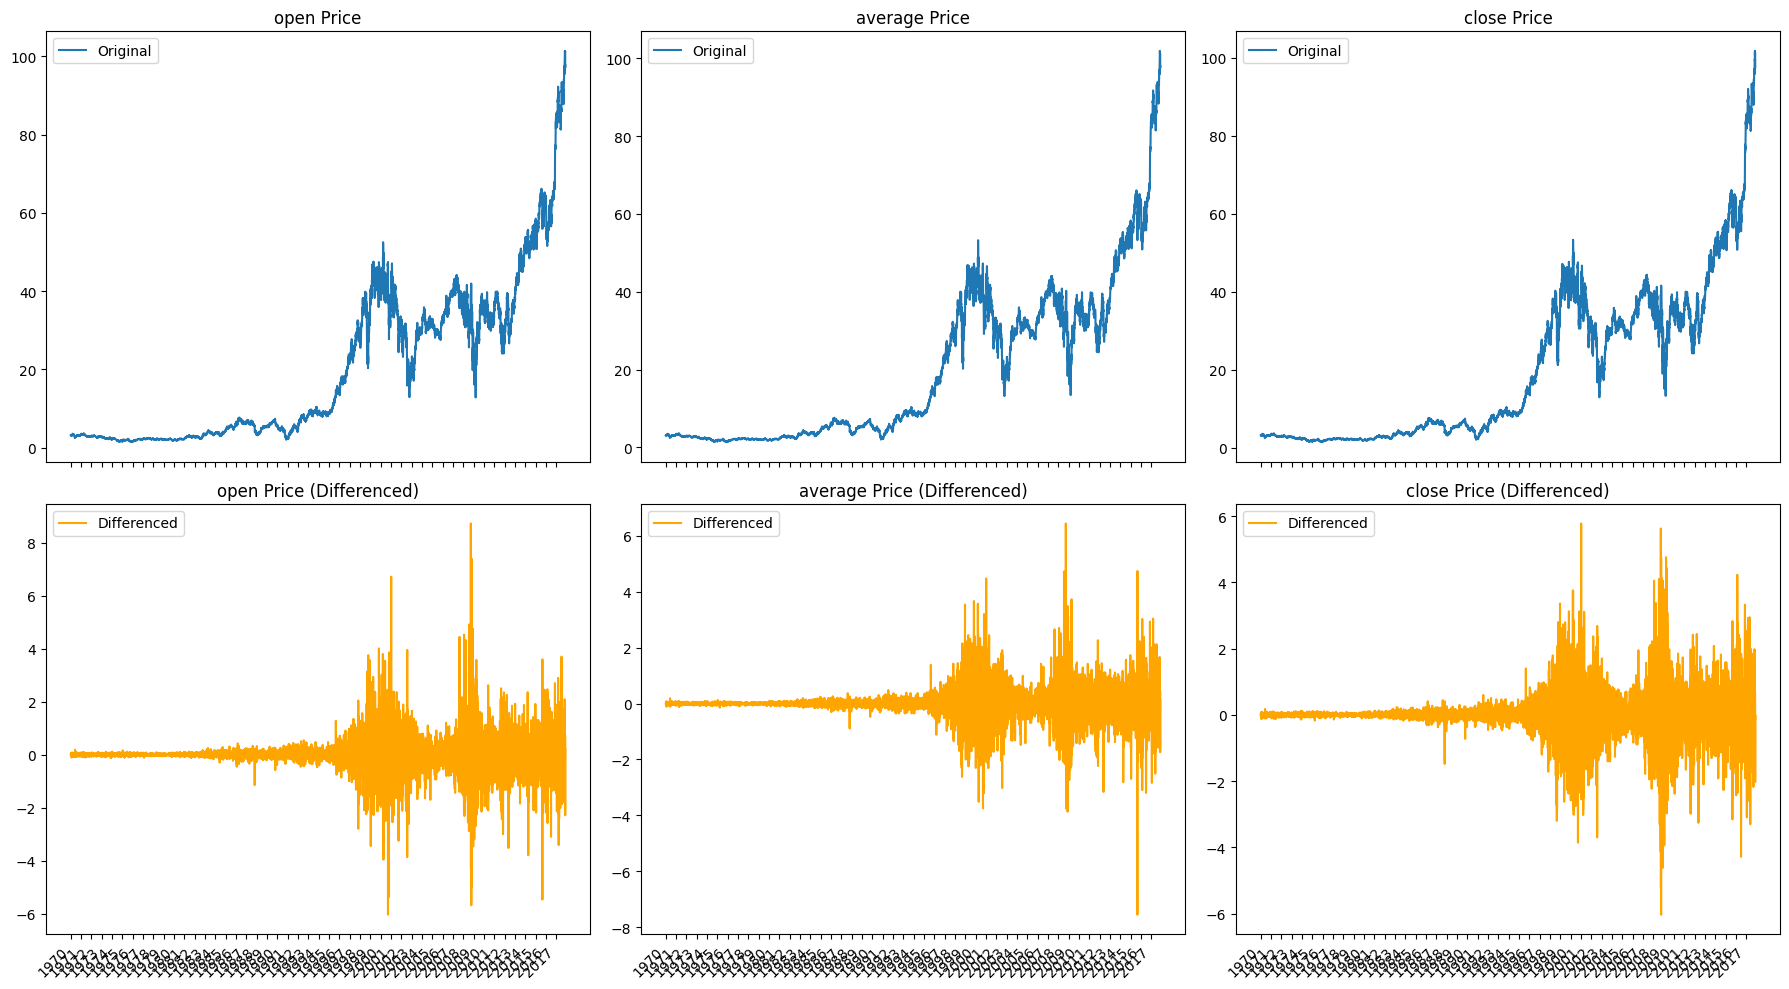

In [24]:
# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
years_in_data = pd.to_datetime(jpm_pivot['Date'], format='%Y-%m-%d').dt.year.unique()
jpm_pivot['Date'] = pd.to_datetime(jpm_pivot['Date'])
tick_locations = [mdates.date2num(pd.to_datetime(f'{year}-01-01')) for year in years_in_data]
tick_labels = years_in_data.astype(str)
jpm_pivot['Date'] = pd.to_datetime(jpm_pivot['Date'])
# 3. Iterate through subplots and apply custom ticks and labels
for i in range(3):
    axes[0, i].set_xticks(tick_locations)
    axes[0, i].set_xticklabels(tick_labels, rotation=45, ha='right')
    axes[1, i].set_xticks(tick_locations)
    axes[1, i].set_xticklabels(tick_labels, rotation=45, ha='right')

# Plot the data
price_types = ['open', 'average', 'close']
for i, price_type in enumerate(price_types):
    # Plot original prices
    axes[0, i].plot(jpm_pivot['Date'], jpm_pivot[price_type], label='Original')
    axes[0, i].set_title(f'{price_type} Price')
    axes[0, i].legend()

    # Plot differenced prices
    axes[1, i].plot(jpm_pivot['Date'], jpm_pivot[f'{price_type}_diff'], label='Differenced', color='orange')
    axes[1, i].set_title(f'{price_type} Price (Differenced)')
    axes[1, i].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [25]:
new_jpm_pivot=jpm_pivot[jpm_pivot['Date'].dt.year >= 2012]
jpm_train,jpm_test=split_data(new_jpm_pivot,0.8)
X_train,X_test=jpm_train[['open_diff','average_diff']],jpm_test[['open_diff','average_diff']]
y_train,y_test=jpm_train['close_diff'],jpm_test['close_diff']

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

RMSE: 1.6828282795407152
MAE: 1.1862338346836327
MSE: 2.8319110184219634


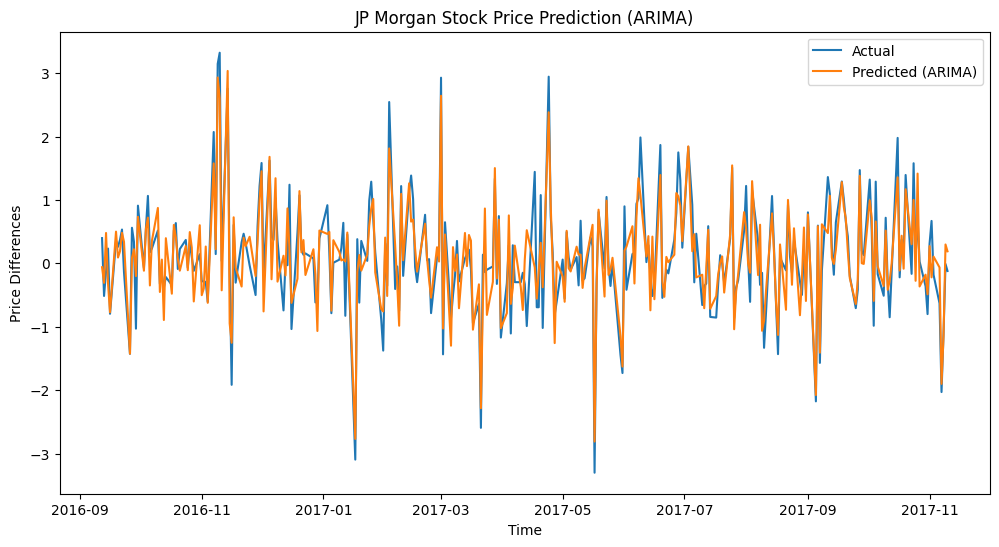

In [26]:
model = ARIMA(y_train, exog=X_train, order=best_order) # Include exog for features
model_fit = model.fit()
# Make predictions on the testing data
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions

rmse = mean_squared_error(aapl_test['close_diff'], predictions, squared=False)
mae = mean_absolute_error(aapl_test['close_diff'], predictions)
mse = mean_squared_error(aapl_test['close_diff'], predictions)
mape = mean_absolute_percentage_error(aapl_test['close_diff'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
plt.figure(figsize=(12, 6))
plt.plot(jpm_test['Date'],jpm_test['close_diff'], label='Actual')
plt.plot(jpm_test['Date'],predictions, label='Predicted (ARIMA)')
plt.title('JP Morgan Stock Price Prediction (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

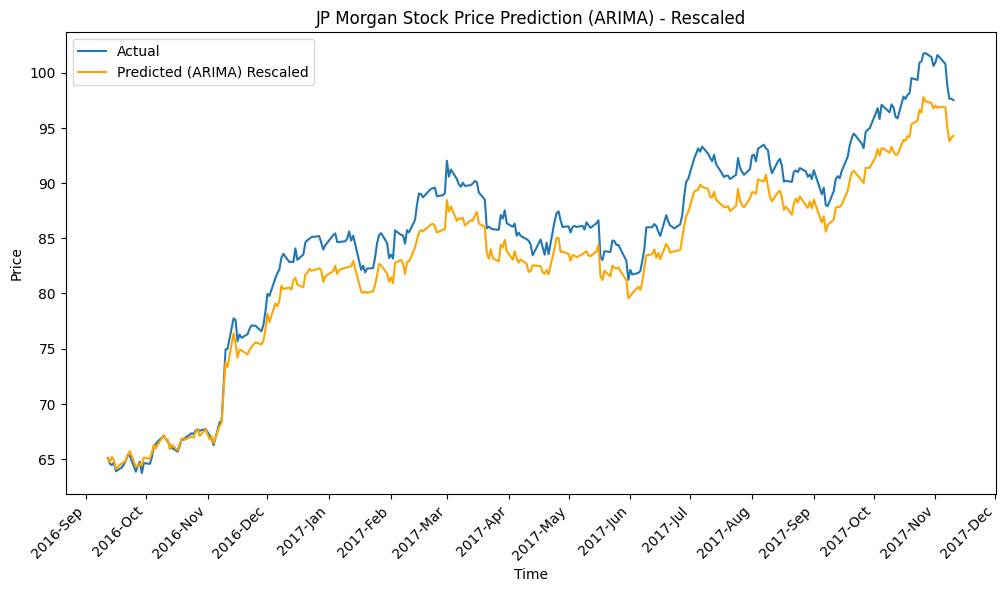

Rescaled RMSE: 55.893251937210316
Rescaled MAE: 54.2777923584798
Rescaled MSE: 3124.0556121164645
Rescaled MAPE: 0.6461930858698455


In [27]:
predictions_rescaled = jpm_test['close'].iloc[0] + predictions.cumsum()

# Plot actual vs. rescaled predicted prices
plt.figure(figsize=(12, 6))
plt.plot(jpm_test['Date'], jpm_test['close'], label='Actual')
plt.plot(jpm_test['Date'], predictions_rescaled, label='Predicted (ARIMA) Rescaled', color='orange')
plt.title('JP Morgan Stock Price Prediction (ARIMA) - Rescaled')
# Convert 'Date' column to datetime
jpm_test['Date'] = pd.to_datetime(jpm_test['Date'], format='%Y-%m-%d')

# Extract unique years and create tick locations/labels
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  # Format as 'Year-Month'
plt.xticks(rotation=45, ha='right')  # Rotate for readability

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate evaluation metrics on rescaled prices
rmse_rescaled = mean_squared_error(aapl_test['close'], predictions_rescaled, squared=False)
mae_rescaled = mean_absolute_error(aapl_test['close'], predictions_rescaled)
mse_rescaled = mean_squared_error(aapl_test['close'], predictions_rescaled)
mape_rescaled = mean_absolute_percentage_error(sp500_test['close'], predictions_rescaled)


# Print the evaluation metrics for rescaled predictions
print(f'Rescaled RMSE: {rmse_rescaled}')
print(f'Rescaled MAE: {mae_rescaled}')
print(f'Rescaled MSE: {mse_rescaled}')
print(f'Rescaled MAPE: {mape_rescaled}')

As you can clearly see, our model performs much worse on this stock. But why? Earlier, we hypothesised that ARIMA models do not generalise volatility well under extreme conditions. In the graph above, comparing the true and predicted stock price, we see one particular outstanding period of extreme volatility. After this time, we begin to see that our model performs poorly when trying to predict subsequent prices. A potential reason which we alluded to earlier is the model's poor ability to predict volatility patterns that are rarely seen in the training set. Let us dissect this issue by visualising the training set and comparing patterns.

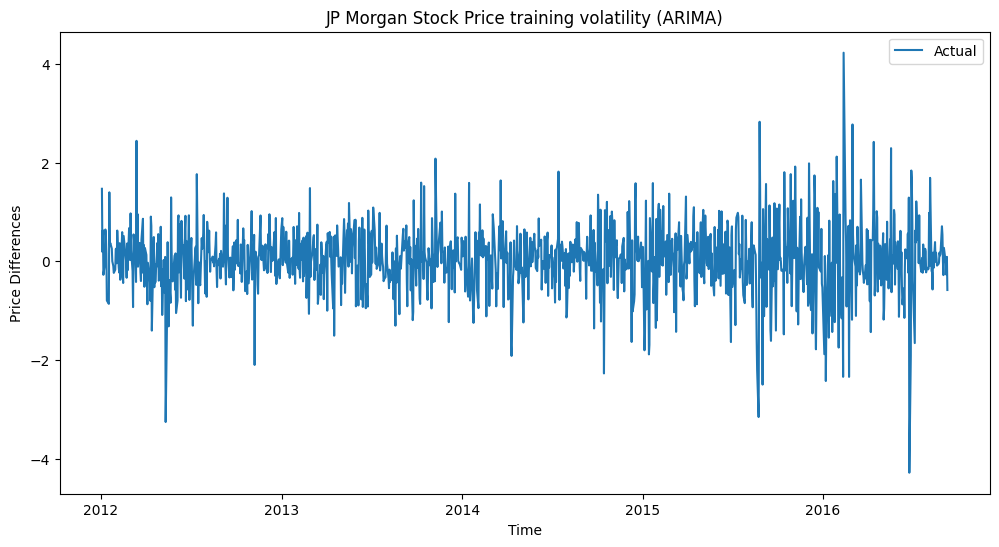

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(jpm_train['Date'],jpm_train['close_diff'], label='Actual')
plt.title('JP Morgan Stock Price training volatility (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

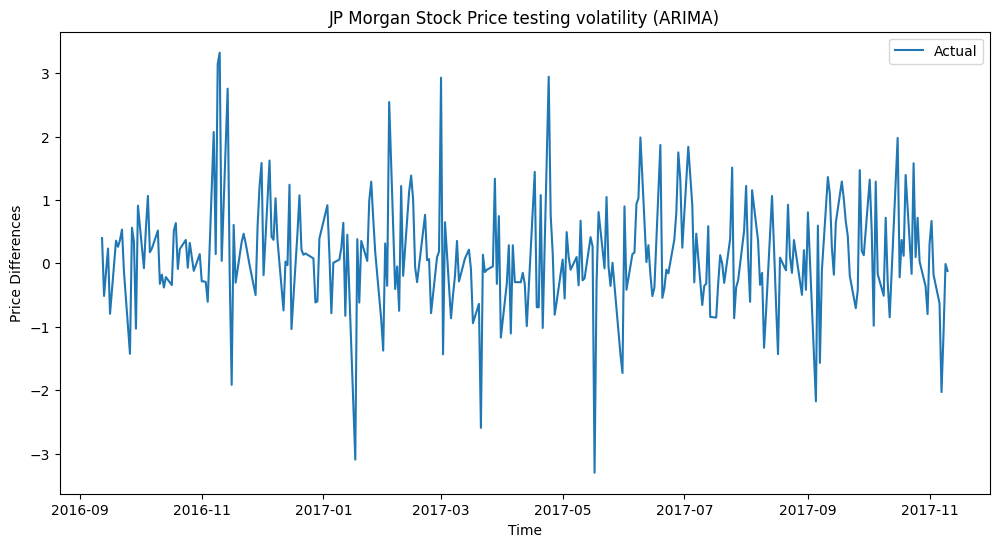

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(jpm_test['Date'],jpm_test['close_diff'], label='Actual')
plt.title('JP Morgan Stock Price testing volatility (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

In [30]:
#cross validate
best_order,best_rmse=grid_search_arima_parallel(
    X_train=X_train,
    y_train=y_train,
    p_values=range(4),
    d_values=range(4),
    q_values=range(4),
    n_jobs=-1,
    n_splits=3,
)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

RMSE: 1.654963897956661
MAE: 1.1625854734446466
MSE: 2.7389055035399057


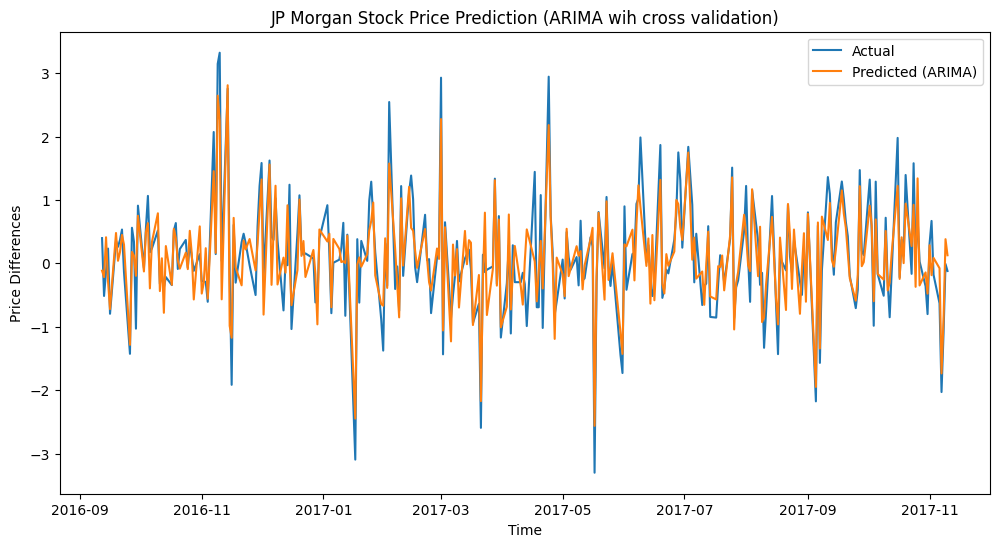

In [31]:
model = ARIMA(y_train, exog=X_train, order=best_order) # Include exog for features
model_fit = model.fit()
# Make predictions on the testing data
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions

rmse = mean_squared_error(aapl_test['close_diff'], predictions, squared=False)
mae = mean_absolute_error(aapl_test['close_diff'], predictions)
mse = mean_squared_error(aapl_test['close_diff'], predictions)
mape = mean_absolute_percentage_error(aapl_test['close_diff'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
plt.figure(figsize=(12, 6))
plt.plot(jpm_test['Date'],jpm_test['close_diff'], label='Actual')
plt.plot(jpm_test['Date'],predictions, label='Predicted (ARIMA)')
plt.title('JP Morgan Stock Price Prediction (ARIMA wih cross validation)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

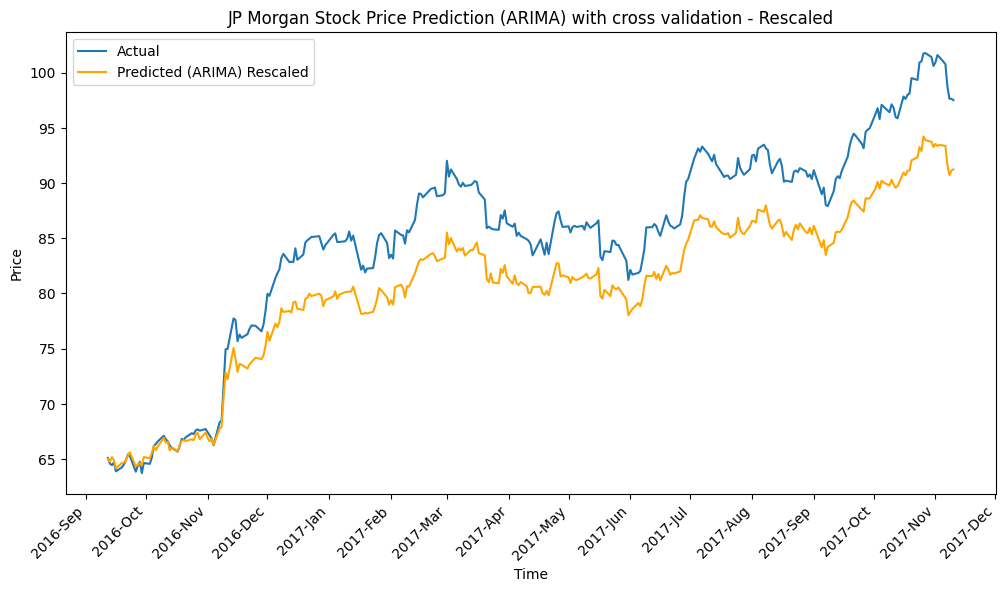

Rescaled RMSE: 4.8029743751831955
Rescaled MAE: 4.377088053944883
Rescaled MSE: 23.068562848666403
Rescaled MAPE: 0.049372808384963066


In [32]:
predictions_rescaled = jpm_test['close'].iloc[0] + predictions.cumsum()

# Plot actual vs. rescaled predicted prices
plt.figure(figsize=(12, 6))
plt.plot(jpm_test['Date'], jpm_test['close'], label='Actual')
plt.plot(jpm_test['Date'], predictions_rescaled, label='Predicted (ARIMA) Rescaled', color='orange')
plt.title('JP Morgan Stock Price Prediction (ARIMA) with cross validation - Rescaled')
# Convert 'Date' column to datetime
jpm_test['Date'] = pd.to_datetime(jpm_test['Date'], format='%Y-%m-%d')

# Extract unique years and create tick locations/labels
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  # Format as 'Year-Month'
plt.xticks(rotation=45, ha='right')  # Rotate for readability

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate evaluation metrics on rescaled prices
rmse_rescaled = mean_squared_error(jpm_test['close'], predictions_rescaled, squared=False)
mae_rescaled = mean_absolute_error(jpm_test['close'], predictions_rescaled)
mse_rescaled = mean_squared_error(jpm_test['close'], predictions_rescaled)
mape_rescaled = mean_absolute_percentage_error(jpm_test['close'], predictions_rescaled)


# Print the evaluation metrics for rescaled predictions
print(f'Rescaled RMSE: {rmse_rescaled}')
print(f'Rescaled MAE: {mae_rescaled}')
print(f'Rescaled MSE: {mse_rescaled}')
print(f'Rescaled MAPE: {mape_rescaled}')

Perhaps there is a fault with the cross validation strategy as we are measuring the best MSE (to account for potential numerical instability issues) of the volatility instead of the MSE of the true against predicted values. We can potentially increase accuracy by adding this step to the cross validation process at the expense of computational operations.

In [33]:
def modified_evaluate_arima_model(X_train, y_train, X_test, y_test, order):
  """Fits an ARIMA model and returns predictions."""
  "takes y_test as true prices instead of z"
  try:
    # Create and fit the ARIMA model on the training data
    model = ARIMA(y_train, exog=X_train, order=order)  # Include exog for features
    model_fit = model.fit()

    # Make predictions on the testing data
    predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions
    predictions_rescaled = jpm_test['close'].iloc[0] + predictions.cumsum()
    mse = mean_squared_error(y_test, predictions_rescaled, squared=True)  # Calculate RMSE

    return order, mse  # Return order and MSE
  except Exception as e:
    print(f"Error with order {order}: {e}")  # Print error message
    return None  # Return None for failed configurations

In [34]:
def modified_grid_search_arima_parallel(X_train, y_train, p_values, d_values, q_values,n_jobs, n_splits):
    """
    Performs a grid search for ARIMA model hyperparameters using parallel computing.

    Args:
        X_train (pd.DataFrame): Features for training.
        y_train (pd.Series): Target variable for training.
        p_values (list): List of values for the AR order (p).
        d_values (list): List of values for the differencing order (d).
        q_values (list): List of values for the MA order (q).
        n_jobs (int): Number of CPU cores to use for parallel processing (-1 for all cores).
        n_splits (int): Number of splits for time series cross-validation.

    Returns:
        tuple: Best ARIMA order and its corresponding RMSE.
    """

    best_order = None
    best_mse = float('inf')
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Create a list of all hyperparameter combinations
    order_param_combinations = [(p, d, q) for p in p_values for d in d_values for q in q_values]
    # sorder_param_combinations = [(P, D, Q,s) for P in P_values for D in D_values for Q in Q_values]

    # Evaluate all model configurations in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(modified_evaluate_arima_model)(
            X_train.iloc[train_idx],  # Features for training split
            y_train.iloc[train_idx],  # Target for training split
            X_train.iloc[validate_idx],  # Features for validation split
            y_train.iloc[validate_idx],  # Target for validation split
            order
        )
        for order in order_param_combinations
        # for sorder in sorder_param_combinations
        for train_idx, validate_idx in tscv.split(X_train)  # Split based on X_train index
    )

    # Filter out failed configurations and find the best model
    valid_results = [result for result in results if result is not None]
    if valid_results:
        best_order, best_mse = min(valid_results, key=lambda x: x[1])

    return best_order, best_mse

In [35]:
#takes y_train as true data instead of differenced data
new_y_train=jpm_train['close']
#cross validate
best_order,best_mse=grid_search_arima_parallel(
    X_train=X_train,
    y_train=new_y_train,
    p_values=range(4),
    d_values=range(4),
    q_values=range(4),
    n_jobs=-1,
    n_splits=3,
)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

RMSE: 0.4204610353306906
MAE: 0.32570463283291695
MSE: 0.17678748223135626


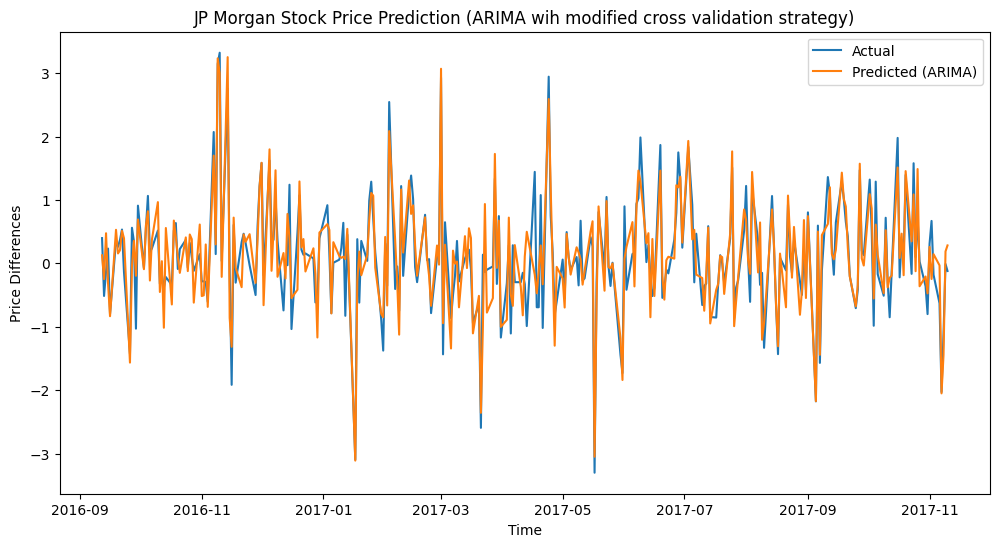

In [36]:
model = ARIMA(y_train, exog=X_train, order=best_order) # Include exog for features
model_fit = model.fit()
# Make predictions on the testing data
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions

rmse = mean_squared_error(jpm_test['close_diff'], predictions, squared=False)
mae = mean_absolute_error(jpm_test['close_diff'], predictions)
mse = mean_squared_error(jpm_test['close_diff'], predictions)
mape = mean_absolute_percentage_error(jpm_test['close_diff'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
plt.figure(figsize=(12, 6))
plt.plot(jpm_test['Date'],jpm_test['close_diff'], label='Actual')
plt.plot(jpm_test['Date'],predictions, label='Predicted (ARIMA)')
plt.title('JP Morgan Stock Price Prediction (ARIMA wih modified cross validation strategy)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

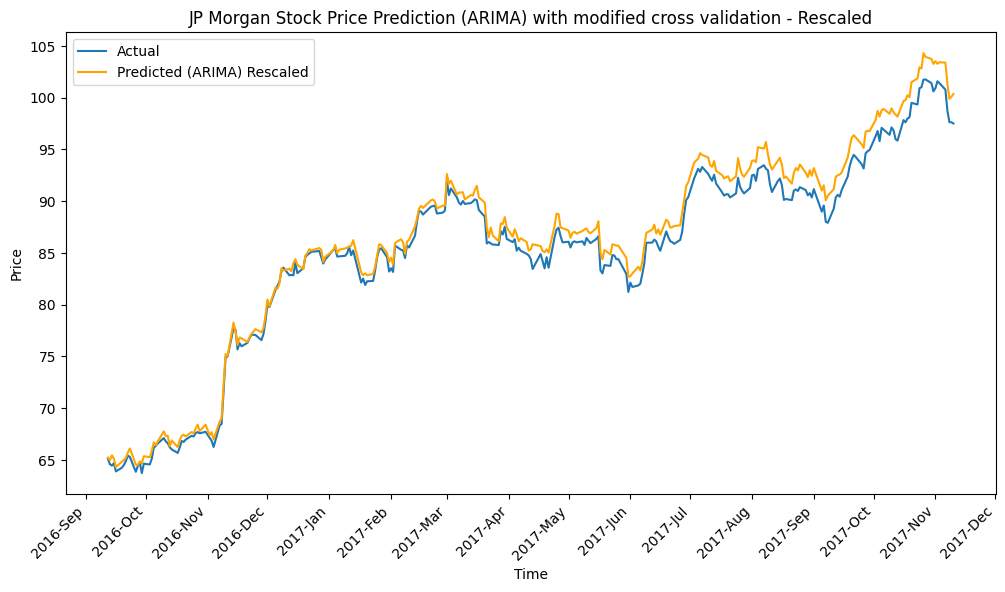

Rescaled RMSE: 1.3268005196507466
Rescaled MAE: 1.1316138748700033
Rescaled MSE: 1.7603996189454916
Rescaled MAPE: 0.012862145429479915


In [37]:
predictions_rescaled = jpm_test['close'].iloc[0] + predictions.cumsum()

# Plot actual vs. rescaled predicted prices
plt.figure(figsize=(12, 6))
plt.plot(jpm_test['Date'], jpm_test['close'], label='Actual')
plt.plot(jpm_test['Date'], predictions_rescaled, label='Predicted (ARIMA) Rescaled', color='orange')
plt.title('JP Morgan Stock Price Prediction (ARIMA) with modified cross validation - Rescaled')
# Convert 'Date' column to datetime
jpm_test['Date'] = pd.to_datetime(jpm_test['Date'], format='%Y-%m-%d')

# Extract unique years and create tick locations/labels
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  # Format as 'Year-Month'
plt.xticks(rotation=45, ha='right')  # Rotate for readability

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate evaluation metrics on rescaled prices
rmse_rescaled = mean_squared_error(jpm_test['close'], predictions_rescaled, squared=False)
mae_rescaled = mean_absolute_error(jpm_test['close'], predictions_rescaled)
mse_rescaled = mean_squared_error(jpm_test['close'], predictions_rescaled)
mape_rescaled = mean_absolute_percentage_error(jpm_test['close'], predictions_rescaled)


# Print the evaluation metrics for rescaled predictions
print(f'Rescaled RMSE: {rmse_rescaled}')
print(f'Rescaled MAE: {mae_rescaled}')
print(f'Rescaled MSE: {mse_rescaled}')
print(f'Rescaled MAPE: {mape_rescaled}')

We see that the model performs visibly better despite showing similar metrics to the other CV strategy without rescaling. Let's try this on Apple and the S&P500 for further investigation and to reach a more concrete conclusion.